In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd

from data_utils import DataSeqLoader
from nn_many2one import *
from data_gen import data_gen

Generate a simulated dataset using `data_gen`.

Here we are assuming that there are 1000 patients, and 20 continuous longitudinal measures (including missingness), and a patient can have up to 30 observations.

In [2]:
df1 = data_gen(n=1000, p=20, max_t=30)

We can observe the number of case and control groups from the simulated data as follows.

`0` means control; `1` means case.

In [3]:
df1.groupby('id').last()['y'].value_counts()

0    904
1     96
Name: y, dtype: int64

We can plot the distribution of the number of observations of the patients, which should approximate a uniform distribution by construction.

<AxesSubplot:ylabel='Density'>

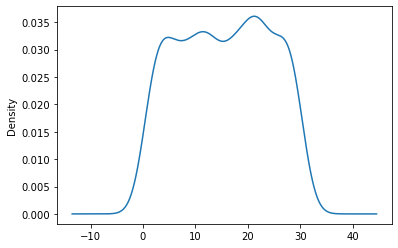

In [7]:
df1['id'].value_counts().sort_index().plot(kind='density')

We also generate a validation set. Then, we dump the data `DataSeqLoader`, which inherites `keras.utils.Sequence` class. It is a structure that sequentialize data into batches of correct shape and format (similar to dataset & dataloader in PyTorch). 

In our usage, we reformat the tabular feature data into `num_predictors x (batch_size, timesteps, 1)`. We can change the argument `many_to_one: bool` to control the output data's shape: `(batch_size, 1)` for `True` and `(batch_size, timesteps, 1)` for `False`.

In [8]:
df2 = data_gen(n=400, p=20, max_t=30)
dl1 = DataSeqLoader(
    X=df1.drop(["id", "y"], axis=1),
    y=df1["y"],
    ids=df1["id"],
    max_t=30,
    batch_size=8,
    many_to_one=True,
)
dl2 = DataSeqLoader(
    X=df2.drop(["id", "y"], axis=1),
    y=df2["y"],
    ids=df2["id"],
    max_t=30,
    batch_size=8,
    many_to_one=True,
)

100%|██████████| 400/400 [00:02<00:00, 159.84it/s]


In [7]:
dl1._rawX

,X0,X0_indctr,X1,X1_indctr,X2,X2_indctr,X3,X3_indctr,X4,X4_indctr,...,X15,X15_indctr,X16,X16_indctr,X17,X17_indctr,X18,X18_indctr,X19,X19_indctr
id,,,,,,,,,,,,,,,,,,,,,
0,-0.560043,1,-999.000000,0,0.870884,1,-0.708569,1,-0.733781,1,...,0.866202,1,0.965692,1,0.682466,1,0.148368,1,-999.000000,0
0,-1.147216,1,-0.635035,1,0.129794,1,0.735650,1,1.395077,1,...,-0.362302,1,-1.410613,1,1.185013,1,-0.367400,1,-0.204227,1
0,-0.661780,1,-999.000000,0,-0.376589,1,-999.000000,0,-999.000000,0,...,-1.341079,1,1.348045,1,-0.326000,1,-0.154832,1,-999.000000,0
0,0.671491,1,-0.343570,1,0.228469,1,0.259081,1,-999.000000,0,...,-0.506024,1,-0.373115,1,0.685376,1,-999.000000,0,-0.329115,1
0,-1.327485,1,-999.000000,0,-999.000000,0,-0.657202,1,0.892753,1,...,-999.000000,0,-999.000000,0,1.703828,1,-1.505204,1,3.146337,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999,-999.000000,0,-999.000000,0,1.006256,1,0.266032,1,-2.096453,1,...,-999.000000,0,-999.000000,0,0.684638,1,-0.821289,1,0.008825,1
999,1.712640,1,-0.046474,1,-1.282425,1,-999.000000,0,-0.275780,1,...,2.069718,1,0.135361,1,-999.000000,0,0.272238,1,-0.194105,1
999,-999.000000,0,0.281259,1,-0.359852,1,0.367331,1,-1.030642,1,...,0.072900,1,0.106902,1,-1.023650,1,-999.000000,0,-0.400770,1


In [28]:
dl1._rawy

id
0      0
0      0
0      0
0      0
0      0
      ..
999    0
999    0
999    0
999    0
999    0
Name: y, Length: 15895, dtype: int64

The model did not implement padding.

In theory, LSTM/RNN models share weights along the time dimension, allowing input data to have varying timesteps. However, in practice, samples in the same batch must share the same timesteps during the training process (because of the way TF/Keras was built). Some engieering tircks has been implemented to ensure that when construct the dataloader.

In [25]:
em = EmbeddingLSTMModel(dl1, True, 2)
em.build()

In [26]:
em.fit(val_data=dl2, filepath="./example.hdf5", metric_curve="ROC", epochs=5)

Epoch 1/5
138/138 [==============================] - 16s 36ms/step - loss: 0.5560 - auc: 0.4805 - val_loss: 0.3909 - val_auc: 0.6355
Epoch 2/5
138/138 [==============================] - 3s 19ms/step - loss: 0.3586 - auc: 0.5073 - val_loss: 0.3656 - val_auc: 0.6344
Epoch 3/5
138/138 [==============================] - 3s 19ms/step - loss: 0.3355 - auc: 0.5241 - val_loss: 0.3542 - val_auc: 0.6145
Epoch 4/5
138/138 [==============================] - 3s 20ms/step - loss: 0.3255 - auc: 0.5063 - val_loss: 0.3469 - val_auc: 0.6104
Epoch 5/5
138/138 [==============================] - 2s 18ms/step - loss: 0.3190 - auc: 0.5315 - val_loss: 0.3438 - val_auc: 0.6023
